# Machine learning - Food

Agarro 6 platos comibinados y busco como se parecen.

In [322]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
from sklearn.cluster import KMeans


In [312]:
with open('data.txt') as f: dishes = f.readlines()
dishes = [dish.replace("\n", "") for dish in dishes]

### Como son nuestros platos?

In [300]:
dishes

['plato combinado 1: pollo, patata, pimiento',
 'plato combinado 2: lomo, huevo, patata, pimiento',
 'plato combinado 3: pechugas, huevo, patata, pimiento',
 'plato combinado 4: ternera, huevo, patata, pimiento',
 'plato combinado 5: asado variado, pimiento verde, pimiento rojo, pechuga pollo, ternera, lomo, patata',
 'plato combinado 6: asado completo, pimiento verde, pimiento rojo, pechuga pollo, ternera, lomo, morcilla, txistorra, patata']

### Convertimos en la matriz de ingredientes

No es muy eficiente. Me da igual por ahora es para probar la idea.

In [301]:
names, ingredients = zip(*[(dish.split(":")[0], dish.split(":")[1].split(",")) for dish in dishes])
unique_ingredients= pd.Series(list(set(x for l in ingredients for x in l)))


def f(phrase) : return [sum(x) for x in zip(*[w==unique_ingredients for w in phrase])]
df = pd.DataFrame([f(ingredient) for ingredient in ingredients], index = names, columns = unique_ingredients)


La matriz quedaria algo asi:

In [304]:
df

,pollo,asado variado,pimiento verde,asado completo,pechugas,pimiento,huevo,ternera,patata,txistorra,pechuga pollo,morcilla,pimiento rojo,lomo
plato combinado 1,1,0,0,0,0,1,0,0,1,0,0,0,0,0
plato combinado 2,0,0,0,0,0,1,1,0,1,0,0,0,0,1
plato combinado 3,0,0,0,0,1,1,1,0,1,0,0,0,0,0
plato combinado 4,0,0,0,0,0,1,1,1,1,0,0,0,0,0
plato combinado 5,0,1,1,0,0,0,0,1,1,0,1,0,1,1
plato combinado 6,0,0,1,1,0,0,0,1,1,1,1,1,1,1


### Machine Learning

Ahora podemos jugar con el machine learning. Usamos el K-means por ejemplo y miramos que platos se parecen. 
Queremos tener ```n_clusters=3``` grupos.

In [306]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
gropped_dishes = pd.DataFrame({"name": names, "group": kmeans.labels_})
gropped_dishes = gropped_dishes.sort_values("group")
gropped_dishes.set_index("group")

,name
group,
0,plato combinado 5
1,plato combinado 1
1,plato combinado 2
1,plato combinado 3
1,plato combinado 4
2,plato combinado 6


Los platos 1-4 se parecen, 5 es distinto y el 6 es distino.

### Como se parecen?

Para calcular la 'pareciencia' entre los platos de momento solo utilizo los ingredientes que le componen. Hacemos la distancia de *yule* que definimos de tal manera:

Sea $v$ vector binario que nos dice si un plato lleva un ingrediente o no. La intuicion:
- Decimos que los dos platos son iguales si llevan los mismos ingredientes. 
- Decimos que los platos se parecen si los ingredientes que llevan coinciden bastante. 
- Decimos que los platos son muy distintos si comparten muy pocos ingredientes. 

La distancia entre plato $i$ e $j$ definimos formalmente como:

$$ 
distancia_{i,j} = 1 - \lVert  \frac{2(\text{numero_de_ingredientes_que_no_comparten})}{\text{numero_total_de_ingredientes}} \rVert  = 1 - \lVert yule.distance_{i,j} \rVert 
$$

Lo que en codigo seria algo que usa paquete *spatial* de la libreria *scipy*



In [350]:
Y = dist.squareform(dist.pdist(np.matrix(df), 'yule'))
dish_similarity = pd.DataFrame((1 - Y / Y.max()).round(2), index=names, columns=names)

Lo que nos va generar una matriz como esta:

In [354]:
dish_similarity

,plato combinado 1,plato combinado 2,plato combinado 3,plato combinado 4,plato combinado 5,plato combinado 6
plato combinado 1,1.00,0.89,0.89,0.89,0.24,0.09
plato combinado 2,0.89,1.00,0.96,0.96,0.46,0.24
plato combinado 3,0.89,0.96,1.00,0.96,0.11,0.00
plato combinado 4,0.89,0.96,0.96,1.00,0.46,0.24
plato combinado 5,0.24,0.46,0.11,0.46,1.00,0.88
plato combinado 6,0.09,0.24,0.00,0.24,0.88,1.00


Asi que podemos dibujar el heatmap y ver que efectivamente los platos 1-4 se parecen mucho, y los 5-6 dos se parecen mas entere ellos per un poco menos. 

Lo bueno que esto es coherente con con el algoritmo de *K-means* y nuestra intuicion.

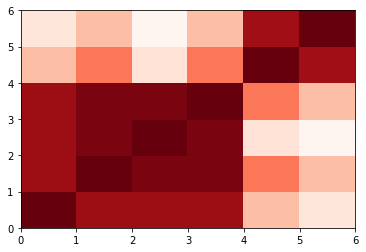

In [356]:
plt.pcolor(dish_similarity, cmap=plt.cm.Reds)
plt.show()

### Ideas para luego...

Hay que preguntarse porque criterios los dos platos se parecen?? Mi idea hasta ahora es:

1. Tienen el mismo nombre 
2. Tienen ingredientes similares
3. El metodo de coccion es el mismo (hervido, frito, al horno, etc.)

Hay que hacer web scrapping de los webs de recetas para sacar esta infomacion y representarla como vectores binarios. A partir de alli tal como lo tenemos. Para el punto 3 mirate el concepto de dummy variables en estadistica.



Yo lo visualizo asi: Desde python hacemos:

``` 
HTTP GET http://donde.sea:9030/dishes/all 

HTTP RESPONSE: JSON 
[{"name":"plato combinado 1", "ingredientes": ["pollo", "patata", "pimiento"], "method": "fried"]}, {...}]

```

A partir de aqui lo convertimos en la matriz de ingredientes y seguimos tal como el PoC de arriba.

#### Otra cosa

Hay que fitrar fuera los ingredientes mas comunes. Ejemplo: todos los platos llevan sal. Pues el hecho de llevar sal no me aporta informacion addicional asi que lo puedo quitar de mi matriz de ingredientes (al menos a efectos de pareciencia).


#### Mañana monto un PoC como quitarlos...